# User Defined Rebound Collision Resolutions
In the [CloseEncounter](https://rebound.readthedocs.io/en/latest/ipython/CloseEncounters.html) example, we discuss methods for resolving collisions in REBOUND through exceptions and the use of the `sim.collision_resolve = "merge"` method.

Using the same 3-Body setup, let's explore how to define and implement bespoke collision resolutions in python and pass them to the `sim.collision_resolve` method.

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

def setupSimulation():
    ''' Setup the 3-Body scenario'''
    sim = rebound.Simulation()
    sim.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    sim.add(m=1.)
    sim.add(m=1e-3, a=1., r=np.sqrt(1e-3/3.)) # we now set collision radii!
    sim.add(m=5e-3, a=1.25, r=1.25*np.sqrt(5e-3/3.))
    sim.move_to_com()
    return sim

To reitterate the previous method, let's run the built-in `merge` collision resolution method

In [2]:
sim = setupSimulation()
sim.collision = "direct"
sim.collision_resolve = "merge" # Built in function

print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))
sim.integrate(100.)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))

Particles in the simulation at t=   0.0: 3
System Mass: [1.0, 0.001, 0.005]
Particles in the simulation at t= 100.0: 2
System Mass: [1.0, 0.006]


We can see above that two particles merged into one with a combined mass of 0.006.

Let's now try to impliment this collision function ourselves!

In [3]:
def my_merge(sim_pointer, collided_particles_index):
    '''
    Merges two colliding particles and removes particle with largest index value

    sim_pointer: A container class for the simulation object in which the
                collision occured. (Use .contents method to retrieve sim object)

    collided_particles_index: Has attributes p1 and p2 which hold 
                              index values of collided particles

    return value 0: Remove no particles from sim
    return value 1: Remove p1 from sim
    return valie 2: Remove p2 from sim
    '''
    sim = sim_pointer.contents # retreive the standard sim object
    ps = sim.particles # easy access to list of particles

    # sometimes p1 and p2 are out of index order so we do this check

    swap = 0 # if swap == 0, p1 and p2 are in order
    i = collided_particles_index.p1 # lower index value
    j = collided_particles_index.p2 # higher index value
    if i > j: # if i is actually higher than j, swap them
        swap = 1 # keeping track of the swap
        i = collided_particles_index.p2 # lower index value
        j = collided_particles_index.p1 # higher index value

    rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
    plt.title("Merging particle {} into {}".format(j, i), fontsize=14)
    plt.text(ps[1].x, ps[1].y, "1", fontsize = 20)
    plt.text(ps[2].x, ps[2].y, "2", fontsize = 20)

    # merge momentum vecotrs
    ps[i].x = (ps[i].x * ps[i].m + ps[j].x * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].y = (ps[i].y * ps[i].m + ps[j].y * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].z = (ps[i].z * ps[i].m + ps[j].z * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].vx = (ps[i].vx * ps[i].m + ps[j].vx * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].vy = (ps[i].vy * ps[i].m + ps[j].vy * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].vz = (ps[i].vz * ps[i].m + ps[j].vz * ps[j].m)/(ps[i].m + ps[j].m)

    ps[i].m = ps[i].m + ps[j].m # merge mass

    ps[i].r = pow(pow(ps[i].r,3.)+pow(ps[j].r,3.),1./3.) # merge radius

    return 1 if swap else 2 # return value coresponding with higher index of p1 or p2

Above we have defined a function that will merge two colliding particles in a totally inelastic collision. 

In the above definition the particle with the highest index value is discarded after collision. This is done to reduce the amount index changes in our particle list

Now let's pass our collision resolution to our sim...

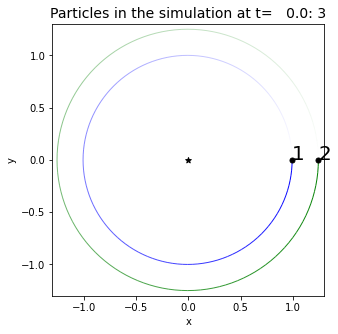

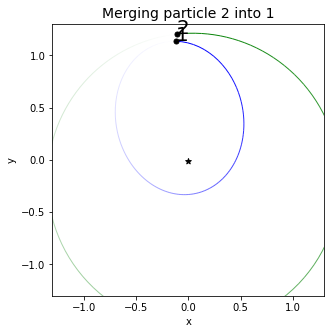

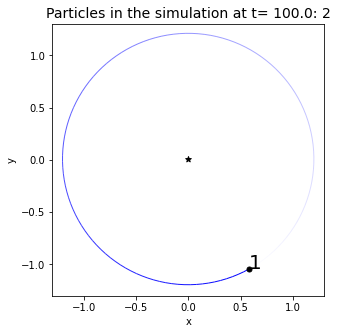

In [4]:
sim = setupSimulation()
sim.collision = "direct"
ps = sim.particles
sim.collision_resolve = my_merge # user defined collision resolution function

rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
plt.title("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N), fontsize=14)
plt.text(ps[1].x, ps[1].y, "1", fontsize = 20)
plt.text(ps[2].x, ps[2].y, "2", fontsize = 20)

sim.integrate(100.)

rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
plt.title("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N), fontsize=14)
plt.text(ps[1].x, ps[1].y, "1", fontsize = 20)
plt.show()


But, let's say we'd prefer to keep merge these two bodies but keep track of the particle that had the most mass going into the collision.

Now we can show off the power of our user defined collision resolver by making just that change!

In [5]:
def my_merge(sim_pointer, collided_particles_index):
    '''
    Merges two colliding particles and removes particle with largest index value

    sim_pointer: A container class for the simulation object in which the
                collision occured. (Use .contents method to retrieve sim object)

    collided_particles_index: Has attributes p1 and p2 which hold 
                              index values of collided particles

    return value 0: Remove no particles from sim
    return value 1: Remove p1 from sim
    return valie 2: Remove p2 from sim
    '''
    sim = sim_pointer.contents # retreive the standard sim object
    ps = sim.particles # easy access to list of particles

    # sometimes p1 and p2 are out of index order so we do this check

    swap = 0 # if swap == 0, p1 and p2 are in order
    i = collided_particles_index.p1 # lower index value
    j = collided_particles_index.p2 # higher index value
    if ps[i].m < ps[j].m: # if mass of p1 is less than p2, switch!
        swap = 1 # keeping track of the swap
        i = collided_particles_index.p2 # lower index value
        j = collided_particles_index.p1 # higher index value

    rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
    plt.title("Merging particle {} into {}".format(j, i), fontsize=14)
    plt.text(ps[1].x, ps[1].y, "1", fontsize = 20)
    plt.text(ps[2].x, ps[2].y, "2", fontsize = 20)

    # merge momentum vecotrs
    ps[i].x = (ps[i].x * ps[i].m + ps[j].x * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].y = (ps[i].y * ps[i].m + ps[j].y * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].z = (ps[i].z * ps[i].m + ps[j].z * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].vx = (ps[i].vx * ps[i].m + ps[j].vx * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].vy = (ps[i].vy * ps[i].m + ps[j].vy * ps[j].m)/(ps[i].m + ps[j].m)
    ps[i].vz = (ps[i].vz * ps[i].m + ps[j].vz * ps[j].m)/(ps[i].m + ps[j].m)

    ps[i].m = ps[i].m + ps[j].m # merge mass

    ps[i].r = pow(pow(ps[i].r,3.)+pow(ps[j].r,3.),1./3.) # merge radius

    return 1 if swap else 2 # return value coresponding with higher index of p1 or p2

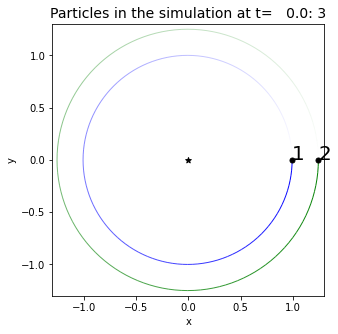

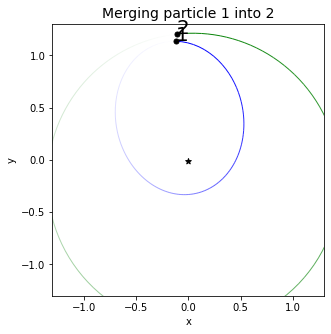

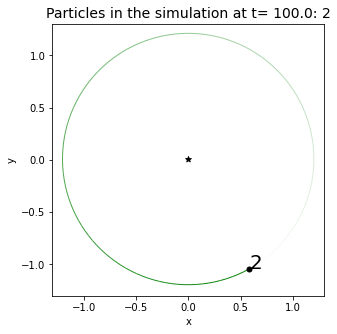

In [6]:
sim = setupSimulation()
sim.collision = "direct"
ps = sim.particles
sim.collision_resolve = my_merge # user defined collision resolution function

rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
plt.title("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N), fontsize=14)
plt.text(ps[1].x, ps[1].y, "1", fontsize = 20)
plt.text(ps[2].x, ps[2].y, "2", fontsize = 20)

sim.integrate(100.)

rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['green'])
plt.title("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N), fontsize=14)
plt.text(ps[1].x, ps[1].y, "2", fontsize = 20)
plt.show()